# Nearest Neighbour

In [1]:
import pandas

datadf = pandas.read_csv('sarcos_inv.csv')
datadf.columns = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22']
datadf.head()



,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
0,0.017279,-0.137077,0.026999,1.532517,0.301344,0.058259,0.128653,-0.153640,-0.335279,0.006449,...,0.017012,-2.211089,11.989628,-7.781117,11.613101,9.550076,14.643369,1.015070,-17.048688,44.104164
1,0.016336,-0.140878,0.027250,1.549670,0.302318,0.059027,0.104104,-0.047313,-0.418732,0.106274,...,0.015857,-2.337160,9.961797,-5.468357,9.550884,5.933340,15.467628,0.910548,-11.415526,37.354858
2,0.016273,-0.145307,0.029072,1.566855,0.307628,0.059027,0.080321,0.053238,-0.460963,0.188013,...,0.007958,-2.331961,7.332938,-2.434889,7.664916,3.964112,10.309203,0.921360,-5.772058,30.676065
3,0.017279,-0.150051,0.031083,1.584416,0.314162,0.059027,0.058840,0.133810,-0.462264,0.263975,...,-0.001271,-2.249311,3.797804,0.467865,6.160604,3.175643,2.868096,1.059957,-0.491542,25.920128
4,0.018818,-0.154544,0.034256,1.602449,0.319723,0.058259,0.036592,0.140750,-0.435916,0.318977,...,-0.006587,-2.123942,0.373019,2.622800,4.442314,2.821629,-1.571357,1.306848,4.210767,17.594261


In [2]:
import matplotlib.pyplot as plt

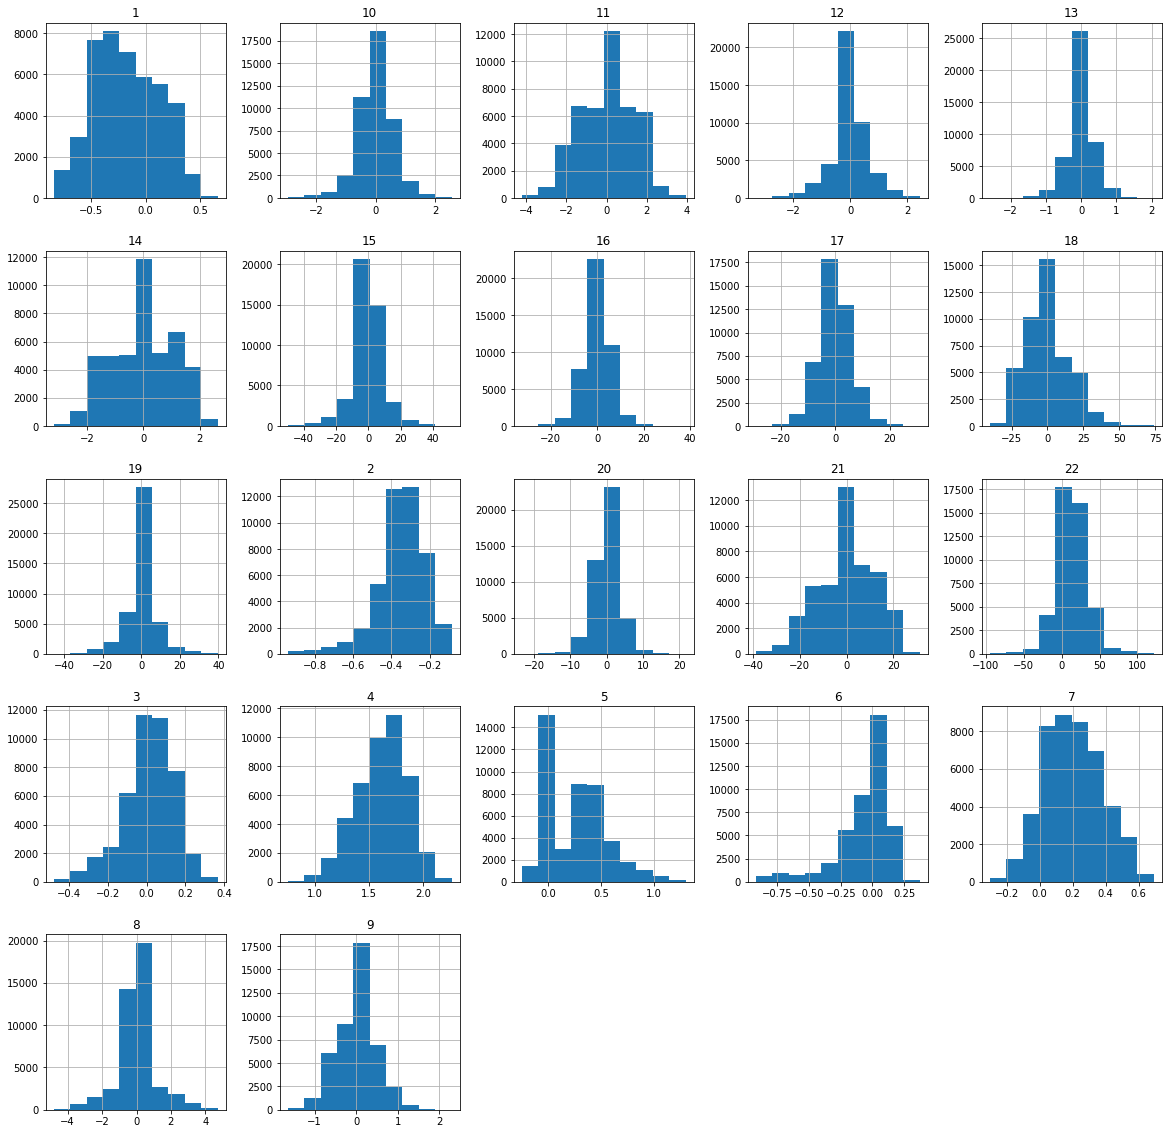

In [3]:
datadf.hist(figsize = (20, 20))
plt.show()

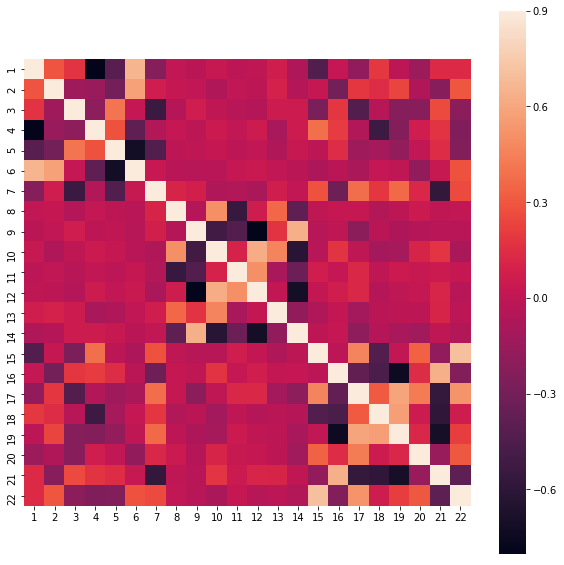

In [4]:
import seaborn as sns

corrmat = datadf.corr()
fig = plt.figure(figsize = (10, 10))

sns.heatmap(corrmat, vmax = 0.9, square = True)
plt.show()

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


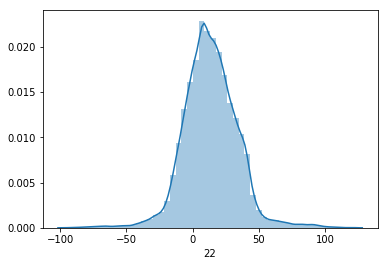

In [5]:
sns.distplot(datadf['22'])

### Nearest Neighbour

In [6]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import KFold


class kNearestNeighborRegressor(object):
    
    """The KNearestNeighborRegressor Object has the following properties:
    
        k : Number of nearest neighbors (default set as 5)
        X : Training matrix of 21 features
        Y : Target values for training set X"""
    
    def __init__(self, k=5):
        self.k = k
    
    def euclideanDistance(self, instance1, instance2):
        """
        Computes the euclidean distance between two data instances.
        It is calculated by finding the sum of the difference between
        value of corresponding features for instance1 and instance2
        and taking a squareroot of it.
        
        Parameters
        ----------
        instance1 : array-like, shape (1, n_features), \
            Data point 1. 
        instance2 : array-like, shape (1, n_features), \
            Data point 2.
        date_index : int
            Index of first non-numerical feature in dataset
        
        Returns
        -------
        euclid_dst : int
            Euclidean distance between instance1 and instance2
        """
        return np.linalg.norm(instance1[:]-instance2[:])
        
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        
    def getMRAE(self, y_pred, y_true):
        """
        Compute the Median Relative Absolute Error
        
        Parameters
        ----------
        y_true : 1d array-like, or label indicator array / sparse matrix
            Ground truth (correct) target values.
        y_pred : 1d array-like, or label indicator array / sparse matrix
            Estimated targets as returned by a classifier.
            
        Returns
        -------
        MRAE: float
            Median Relative Absolute Error of the model
        """
        return np.median(np.abs(y_pred - y_true) / y_true)
        
    def getNeighbors(self, testInstance, n_neighbors=None):
        """
        Finds the K-neighbors of a point while avoiding time leakage.
        Returns indices of the neighbors and distances to the 
        neighbors of each point. This is calculated by finding the 
        euclidean distance between the testInstance and all the 
        instances in the training set X. Top k number of members 
        with the smallest values of euclidean distance are collected
        and returned.
        
        Parameters
        ----------
        testInstance : array-like, shape (1, n_features), \
            The query point.
        n_neighbors : int
            Number of neighbors to get (default is the value
            passed to the constructor).
        
        Returns
        -------
        distances : array
            Array representing the lengths to points, only present if
            return_distance=True
        neighbors : array
            Indices of the nearest points in the population matrix.        
        """
        if n_neighbors is None:
            n_neighbors = self.k                    # Default is set as k = 5
        distances = []
        for j in range(len(self.X_train)):
            dist = self.euclideanDistance(testInstance, self.X_train[j])   # Calculate euclidean distance
            distances.append((j, dist))
        distances.sort(key=lambda t: t[1])          # Sort the distances in ascending order
        neighbors = []
        if len(distances) >= n_neighbors:
            for j in range(n_neighbors):
                neighbors.append(distances[j][0])
        else:
            for j in range(len(distances)):
                neighbors.append(distances[j][0])
        distances = [t[1] for t in distances[:n_neighbors]]
        return np.array(distances), np.array(neighbors)
    
    def getWeights(self, dist):
        """
        Compute the weighted points of the neighbor data distances
        by the inverse of their distance.
        
        Parameters
        ===========
        dist: ndarray
            The input distances
        
        Returns
        ========
        weights_arr: array of the same shape as ``dist``
            Weighted Points
        """
        for point_dist_i, point_dist in enumerate(dist):
            
            # check if point_dist is iterable
            # (ex: RadiusNeighborClassifier.predict may set an element of
            # dist to 1e-6 to represent an 'outlier')
            
            if hasattr(point_dist, '__contains__') and 0. in point_dist:
                dist[point_dist_i] = point_dist == 0.
            else:
                dist[point_dist_i] = 1. / point_dist

        return dist

    def getPrediction(self, testInstance):
        """
        Predict the target value for the provided data instance
        
        Parameters
        ----------
        testInstance : array-like, shape (1, n_features), \
            The query point.
        
        Returns
        -------
        y_pred: float
            Target Value
        """
        neigh_dist, neigh_ind = self.getNeighbors(testInstance)
        
        if neigh_ind.size == 0:                       # For datapoint with no neighbors, mean of target values is taken
            return np.mean(self.y_train)
        
        weights = self.getWeights(neigh_dist)         # Calculate weights corresponding to each neighbor

        if weights is None:
            y_pred = np.mean(self.y_train[neigh_ind]) 
        else:
            denom = np.sum(weights)
            num = np.sum(self.y_train[neigh_ind] * weights)
            y_pred = num/denom
        return y_pred
    
    def getPredictions(self, X):
        """
        Predict the target for multiple data instances
        Parameters
        ----------
        X : array-like, shape (n_query, n_features), \
                or (n_query, n_indexed) if metric == 'precomputed'
            Test samples.
        Returns
        -------
        y : array of int, shape = [n_samples] or [n_samples, n_outputs]
            Target values
        """
        y_pred = []

        for j in range(len(X)):
            if j % 1000 == 0:
                print ('Iteration: ', j)
            result = self.getPrediction(X[j])
            y_pred.append(result)
        print()

        return np.array(y_pred)





C:\Program Files\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Iteration:  0
Iteration:  1000
Iteration:  2000
Iteration:  3000
Iteration:  4000
Iteration:  5000
Iteration:  6000
Iteration:  7000
Iteration:  8000
Iteration:  9000
Iteration:  10000
Iteration:  11000
Iteration:  12000
Iteration:  13000
Iteration:  14000
Iteration:  15000
Iteration:  16000
Iteration:  17000

The Median Relative Absolute Error of our KNN Regressor is: 0.30929148782601795

Mean Squared Error is:  143.19239737922004
Root Mean Squared Error is:  0.49112018405236907


C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in true_divide


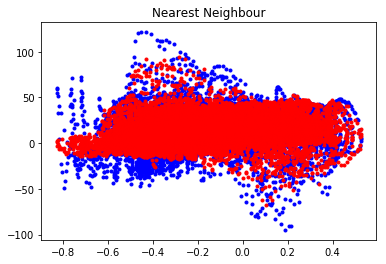

Runtime:  2952.9525025000003  seconds


In [7]:
if __name__ == '__main__':
    
    import timeit
    start_time = timeit.default_timer()

    #store response vector in "torques"
    torques = datadf.pop('22').values
    #store feature matrix in "X"
    X = datadf.values

    #Split SARCOS data Into Training and Test Sets
    split = int(X.shape[0] * 0.6)

    X_train = X[:split,:]
    torques_train = torques[:split]

    X_test = X[split:,:]
    torques_test = torques[split:]
                
    knn = kNearestNeighborRegressor(k=4)
    knn.fit(X_train, torques_train)

    # ## Model Performance

    torques_pred = knn.getPredictions(X_test)
    print ('The Median Relative Absolute Error of our KNN Regressor is: %s' %knn.getMRAE(torques_pred, torques_test))
    print()
    mse = np.mean((torques_test - torques_pred)**2)
    print('Mean Squared Error is: ', mse)
    rmse = np.mean((torques_test - torques_pred))
    print('Root Mean Squared Error is: ', rmse)
    
    plt.figure()
    plt.plot(X_test[:,0],torques_test,'b.')
    plt.plot(X_test[:,0],torques_pred,'r.')
    plt.title('Nearest Neighbour')
    plt.show()
    
    elapsed = timeit.default_timer() - start_time
    print('Runtime: ' , elapsed, ' seconds')

### Toy Problem 1: Exponential Sinusoidal Waveform

Iteration:  0

Mean Squared Error is:  0.04167960699370779


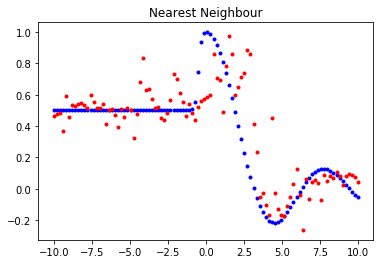

In [8]:
import math

##Example insipired from 'Learning Gaussian Process Models from Uncertain Data', Dallaire.
if __name__=="__main__":
    def sincsig(x):
        return (x>=0)*np.sinc(x/math.pi)+(x<0)*(0.5*(1 + np.exp(-10*x-5))**(-1)+0.5)
        
        
    X_train=np.random.random((150,1))*20.0-10.0
    y_train=sincsig(X_train[:,0])
    
    X_std = np.random.random(X_train.shape)*2.0+0.5
    y_std= 0.1*np.ones_like(y_train)
    y_train += np.random.normal(0.0,y_std)
    X_train += np.random.normal(0.0,X_std)
    
    X_test=np.linspace(-10,10,100).reshape(-1,1)
    y_test=sincsig(X_test[:,0])
    
    knn = kNearestNeighborRegressor(k=4)
    knn.fit(X_train, y_train)
    
    y_pred = knn.getPredictions(X_test)
    y_pred_std = y_pred.std()
    
    mse = np.mean((y_test - y_pred)**2)
    print('Mean Squared Error is: ', mse)
    
    plt.figure()
    plt.plot(X_test[:,0],y_test,'b.')
    plt.plot(X_test[:,0],y_pred,'r.')
    plt.title('Nearest Neighbour')
    plt.show()

### Toy Problem 2: Abalone Age Prediction

In [9]:
import pandas

abalonedf = pandas.read_csv('abalone.csv')

toyprob2df = abalonedf[['Length','Height','Whole weight','Rings']][:500]
toyprob2df.head()

,Length,Height,Whole weight,Rings
0,0.455,0.095,0.5140,15
1,0.350,0.090,0.2255,7
2,0.530,0.135,0.6770,9
3,0.440,0.125,0.5160,10
4,0.330,0.080,0.2050,7


Iteration:  0

The Median Relative Absolute Error of our KNN Regressor is: 0.1583504954126803

Mean Squared Error is:  10.494479387218762


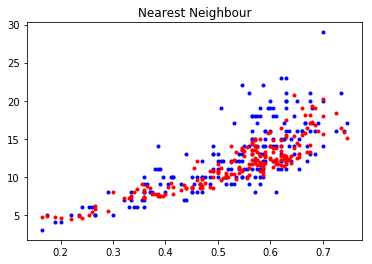

In [10]:
y = toyprob2df.pop('Rings').values
#store feature matrix in "X"
X = toyprob2df.values

#Split Abalone data Into Training and Test Sets
split = int(X.shape[0] * 0.6)

X_train = X[:split,:]
y_train = y[:split]

X_test = X[split:,:]
y_test = y[split:]
                
knn = kNearestNeighborRegressor(k=4)
knn.fit(X_train, y_train)

# ## Model Performance

y_pred_tp = knn.getPredictions(X_test)
print ('The Median Relative Absolute Error of our KNN Regressor is: %s' %knn.getMRAE(y_pred_tp, y_test))
print()
mse = np.mean((y_test - y_pred_tp)**2)
print('Mean Squared Error is: ', mse)

plt.figure()
plt.plot(X_test[:,0],y_test,'b.')
plt.plot(X_test[:,0],y_pred_tp,'r.')
plt.title('Nearest Neighbour')
plt.show()

### Comparison to SKLearn Model

In [11]:
import pandas

datadf = pandas.read_csv('sarcos_inv.csv')
datadf.columns = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22']
datadf.head()



,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
0,0.017279,-0.137077,0.026999,1.532517,0.301344,0.058259,0.128653,-0.153640,-0.335279,0.006449,...,0.017012,-2.211089,11.989628,-7.781117,11.613101,9.550076,14.643369,1.015070,-17.048688,44.104164
1,0.016336,-0.140878,0.027250,1.549670,0.302318,0.059027,0.104104,-0.047313,-0.418732,0.106274,...,0.015857,-2.337160,9.961797,-5.468357,9.550884,5.933340,15.467628,0.910548,-11.415526,37.354858
2,0.016273,-0.145307,0.029072,1.566855,0.307628,0.059027,0.080321,0.053238,-0.460963,0.188013,...,0.007958,-2.331961,7.332938,-2.434889,7.664916,3.964112,10.309203,0.921360,-5.772058,30.676065
3,0.017279,-0.150051,0.031083,1.584416,0.314162,0.059027,0.058840,0.133810,-0.462264,0.263975,...,-0.001271,-2.249311,3.797804,0.467865,6.160604,3.175643,2.868096,1.059957,-0.491542,25.920128
4,0.018818,-0.154544,0.034256,1.602449,0.319723,0.058259,0.036592,0.140750,-0.435916,0.318977,...,-0.006587,-2.123942,0.373019,2.622800,4.442314,2.821629,-1.571357,1.306848,4.210767,17.594261


In [12]:
import timeit
start_time = timeit.default_timer()

from sklearn.neighbors import KNeighborsRegressor
import numpy as np

torques = datadf.pop('22').values

X = datadf.values

#Split SARCOS data Into Training and Test Sets
split = int(X.shape[0] * 0.6)

X_train = X[:split,:]
torques_train = torques[:split]

X_test = X[split:,:]
torques_test = torques[split:]


neigh = KNeighborsRegressor(n_neighbors=4)
neigh.fit(X_train, torques_train)
sktorques_pred = neigh.predict(X_test)

mse = np.mean((torques_test - sktorques_pred)**2)
print('Mean Squared Error is: ', mse)

elapsed = timeit.default_timer() - start_time
print('Runtime: ' , elapsed, ' seconds')

Mean Squared Error is:  143.34955978602457
Runtime:  1.324814399999923  seconds
